In [3]:
import typing as t
import pathlib
import os
import pickle
import collections
import timeit

import transformers
import optimum
import optimum.onnxruntime
import onnxruntime
import onnx
import datasets
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm.auto
import pandas as pd

import segmentador
import segmentador.optimize
import eval_model
import prune_heads

%load_ext autoreload
%autoreload 2


PRUNE_HEADS = False

PERFORMANCE_LOGS_DIR = "performance_logs"
pathlib.Path(PERFORMANCE_LOGS_DIR).mkdir(exist_ok=True, parents=True)

QUANTIZED_MODELS_DIR = "quantized_models"
pathlib.Path(QUANTIZED_MODELS_DIR).mkdir(exist_ok=True, parents=True)

In [2]:
curated_df = datasets.Dataset.from_file(
    "../data/refined_datasets/df_tokenized_split_0_120000_6000/"
    "combined_test_48_parts_1036_instances/dataset.arrow"
)

curated_df_subsample = curated_df.shard(num_shards=200, index=0)

## Pruning transformers heads

In [3]:
if PRUNE_HEADS:
    device = "cuda"

    segmenter_bert = segmentador.BERTSegmenter(
        uri_model="../pretrained_segmenter_model/2_6000_layer_model/",
        device=device,
    )

    eval_df = datasets.Dataset.from_file(
        "../data/df_tokenized_split_0_120000_6000/eval/dataset.arrow"
    ).shard(num_shards=20, index=0)

    eval_dataloader = torch.utils.data.DataLoader(
        eval_df,
        sampler=torch.utils.data.SequentialSampler(eval_df),
        batch_size=4,
        collate_fn=transformers.DataCollatorForTokenClassification(
            segmenter_bert.tokenizer,
            padding="max_length",
            max_length=1024,
        ),
    )

    head_mask = prune_heads.mask_heads(
        segmenter_bert.model,
        eval_dataloader,
        device=device,
        masking_threshold=0.995,
    )

    prune_heads.prune_heads(
        segmenter_bert.model,
        eval_dataloader,
        head_mask,
        device=device,
    )

    segmenter_bert.model.save_pretrained("head_pruning/pruned_model")
    segmenter_bert.tokenizer.save_pretrained("head_pruning/pruned_model")

- masking_threshold = 0.995
    - Pruning: original num of params: 1.96e+07, after pruning 1.76e+07 (89.9%)
    - Pruning: score with masking: 0.9825 score with pruning: 0.9825
    - Pruning: speed ratio (new timing / original timing): 131.32%

- masking_threshold = 0.990
    - Pruning: original num of params: 1.96e+07, after pruning 1.68e+07 (85.9%)
    - Pruning: score with masking: 0.9791 score with pruning: 0.9791
    - Pruning: speed ratio (new timing / original timing): 145.23%

- masking_threshold = 0.980
    - Pruning: original num of params: %.2e, after pruning %.2e (%.1f percents) 19576324 16427524 83.91526417319206
    - Pruning: score with masking: %f score with pruning: %f 0.971903741967998 0.971903741967998
    - Pruning: speed ratio (new timing / original timing): %f percents 151.18013865026202

## Quantizing LSTM

In [4]:
segmenter_lstm = segmentador.LSTMSegmenter(
    uri_model="../pretrained_segmenter_model/512_6000_1_lstm/checkpoints/epoch=3-step=3591.ckpt",
    uri_tokenizer="../tokenizers/6000_subwords",
    device="cpu",
)

### As Torch JIT format

In [5]:
quantized_lstm_torch_paths = segmentador.optimize.quantize_model(
    segmenter_lstm,
    model_output_format="torch_jit",
    check_cached=False,
    verbose=True,
)

Saved quantized Pytorch module (Torch JIT format) in './quantized_models/q_segmenter_num_layers_1_vocab_size_6000_lstm_model.pt'. To use it, load a LSTM segmenter model as:

segmentador.optimize.TorchJITLSTMSegmenter(
   uri_model='./quantized_models/q_segmenter_num_layers_1_vocab_size_6000_lstm_model.pt',
   ...,
)


In [6]:
segmenter_lstm_torch_quantized = segmentador.optimize.TorchJITLSTMSegmenter(
    uri_model=quantized_lstm_torch_paths.output_uri,
)

In [7]:
segmenter_lstm_torch_quantized(curated_df_subsample, show_progress_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

['INDICAÇÃO Nº DE 2008 ( Do Sr. Hermes Parcianello )',
 'Indica ao Ministério da Educação a inclusão no ProInfância do município de LARANJEIRAS DO SUL, no estado do Paraná.',
 'Excelentíssimo Senhor Ministro de Estado da Educação, Considerando que a construção de creches e escolas de educação infantil e a reestruturação e aquisição de equipamentos para a rede física escolar desse nível educacional são indispensáveis à melhoria da educação. Considerando um grande percentual de mulheres chefes de família com filhos menores que necessitam de local adequado para deixar seus filhos e que o Programa disponibiliza o atendimento de até 120 crianças em período integral ou até 240 crianças, se distribuídos em turnos matutinos e vespertinos. Considerando que o município ao ser atendido pelo Programa priorizará a acessibilidade, fazendo as adequações necessárias a fim de permitir seu uso por portadores de necessidades especiais. Considerando que a edificação será composta de um bloco administrativ

### As ONNX format

In [8]:
quantized_lstm_onnx_paths = segmentador.optimize.quantize_model(
    segmenter_lstm,
    model_output_format="onnx",
    check_cached=False,
    verbose=True,
)

/media/nvme/segmentador/venvs/env3.9.10/lib/python3.9/site-packages/torch/onnx/symbolic_opset9.py:2188: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn("Exporting a model to ONNX with a batch_size other than 1, " +
/media/nvme/segmentador/venvs/env3.9.10/lib/python3.9/site-packages/torch/onnx/symbolic_helper.py:719: UserWarning: allowzero=0 by default. In order to honor zero value in shape use allowzero=1
  warnings.warn("allowzero=0 by default. In order to honor zero value in shape use allowzero=1")


Saved quantized Pytorch module (ONNX format) in './quantized_models/q_segmenter_hidden_layer_dim_512_vocab_size_6000_num_layers_1_lstm_model_99_opt_level.onnx'. To use it, load a LSTM segmenter model as:

segmentador.optimize.ONNXLSTMSegmenter(
   uri_model='./quantized_models/q_segmenter_hidden_layer_dim_512_vocab_size_6000_num_layers_1_lstm_model_99_opt_level.onnx',
   uri_tokenizer='../tokenizers/6000_subwords',
   ...,
)


2022-04-28 23:52:02.955978960 [W:onnxruntime:, inference_session.cc:1546 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.


In [9]:
segmenter_lstm_onnx_quantized = segmentador.optimize.ONNXLSTMSegmenter(
    uri_model=quantized_lstm_onnx_paths.output_uri,
    uri_tokenizer=segmenter_lstm.tokenizer.name_or_path,
)

In [10]:
segmenter_lstm_onnx_quantized(curated_df_subsample, show_progress_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

['INDICAÇÃO Nº DE 2008 ( Do Sr. Hermes Parcianello )',
 'Indica ao Ministério da Educação a inclusão no ProInfância do município de LARANJEIRAS DO SUL, no estado do Paraná.',
 'Excelentíssimo Senhor Ministro de Estado da Educação, Considerando que a construção de creches e escolas de educação infantil e a reestruturação e aquisição de equipamentos para a rede física escolar desse nível educacional são indispensáveis à melhoria da educação. Considerando um grande percentual de mulheres chefes de família com filhos menores que necessitam de local adequado para deixar seus filhos e que o Programa disponibiliza o atendimento de até 120 crianças em período integral ou até 240 crianças, se distribuídos em turnos matutinos e vespertinos. Considerando que o município ao ser atendido pelo Programa priorizará a acessibilidade, fazendo as adequações necessárias a fim de permitir seu uso por portadores de necessidades especiais. Considerando que a edificação será composta de um bloco administrativ

## Quantizing BERT

In [11]:
segmenter_bert = segmentador.BERTSegmenter(
    uri_model="../pretrained_segmenter_model/2_6000_layer_model/",
    device="cpu",
)

### As Torch JIT format

In [12]:
quantized_bert_torch_paths = segmentador.optimize.quantize_model(
    segmenter_bert,
    model_output_format="torch_jit",
    check_cached=False,
    verbose=True,
)

Saved quantized Pytorch module (Torch JIT format) in './quantized_models/q_segmenter_num_layers_2_vocab_size_6000_pruned_False_bert_model.pt'. To use it, load a BERT segmenter model as:

segmentador.optimize.TorchJITBERTSegmenter(
   uri_model='./quantized_models/q_segmenter_num_layers_2_vocab_size_6000_pruned_False_bert_model.pt',
   ...,
)


In [13]:
segmenter_bert_torch_quantized = segmentador.optimize.TorchJITBERTSegmenter(
    uri_model=quantized_bert_torch_paths.output_uri,
)

In [14]:
segmenter_bert_torch_quantized(curated_df_subsample, show_progress_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

['INDICAÇÃO Nº DE 2008 ( Do Sr. Hermes Parcianello )',
 'Indica ao Ministério da Educação a inclusão no ProInfância do município de LARANJEIRAS DO SUL, no estado do Paraná.',
 'Excelentíssimo Senhor Ministro de Estado da Educação, Considerando que a construção de creches e escolas de educação infantil e a reestruturação e aquisição de equipamentos para a rede física escolar desse nível educacional são indispensáveis à melhoria da educação. Considerando um grande percentual de mulheres chefes de família com filhos menores que necessitam de local adequado para deixar seus filhos e que o Programa disponibiliza o atendimento de até 120 crianças em período integral ou até 240 crianças, se distribuídos em turnos matutinos e vespertinos. Considerando que o município ao ser atendido pelo Programa priorizará a acessibilidade, fazendo as adequações necessárias a fim de permitir seu uso por portadores de necessidades especiais. Considerando que a edificação será composta de um bloco administrativ

### As ONNX format

In [15]:
quantized_bert_onnx_paths = segmentador.optimize.quantize_model(
    segmenter_bert,
    model_output_format="onnx",
    check_cached=False,
    verbose=True,
)

2022-04-28 23:52:08.476016191 [W:onnxruntime:, inference_session.cc:1546 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.


failed in shape inference <class 'AssertionError'>
failed in shape inference <class 'AssertionError'>
Saved quantized BERT (ONNX format) in './quantized_models/q_segmenter_num_layers_2_vocab_size_6000_pruned_False_bert_model_99_opt_level.onnx', and its configuration file in './quantized_models/q_segmenter_num_layers_2_vocab_size_6000_pruned_False_bert_model_99_opt_level.config'. To use it, load a BERT segmenter model as:

segmentador.optimize.ONNXBERTSegmenter(
   uri_model='./quantized_models/q_segmenter_num_layers_2_vocab_size_6000_pruned_False_bert_model_99_opt_level.onnx',
   uri_tokenizer='../pretrained_segmenter_model/2_6000_layer_model/',
   uri_onnx_config='./quantized_models/q_segmenter_num_layers_2_vocab_size_6000_pruned_False_bert_model_99_opt_level.config',
   ...,
)


In [16]:
segmenter_bert_onnx_quantized = segmentador.optimize.ONNXBERTSegmenter(
    uri_model=quantized_bert_onnx_paths.output_uri,
    uri_tokenizer=segmenter_bert.tokenizer.name_or_path,
    uri_onnx_config=quantized_bert_onnx_paths.onnx_config_uri,
)

In [17]:
segmenter_bert_onnx_quantized(curated_df_subsample, show_progress_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

['INDICAÇÃO Nº DE 2008 ( Do Sr. Hermes Parcianello )',
 'Indica ao Ministério da Educação a inclusão no ProInfância do município de LARANJEIRAS DO SUL, no estado do Paraná.',
 'Excelentíssimo Senhor Ministro de Estado da Educação, Considerando que a construção de creches e escolas de educação infantil e a reestruturação e aquisição de equipamentos para a rede física escolar desse nível educacional são indispensáveis à melhoria da educação. Considerando um grande percentual de mulheres chefes de família com filhos menores que necessitam de local adequado para deixar seus filhos e que o Programa disponibiliza o atendimento de até 120 crianças em período integral ou até 240 crianças, se distribuídos em turnos matutinos e vespertinos. Considerando que o município ao ser atendido pelo Programa priorizará a acessibilidade, fazendo as adequações necessárias a fim de permitir seu uso por portadores de necessidades especiais. Considerando que a edificação será composta de um bloco administrativ

## Quantizing Pruned BERT

### As Torch JIT format

In [18]:
segmenter_pruned_bert = segmentador.BERTSegmenter(
    uri_model="head_pruning/pruned_model",
    device="cpu",
)

In [19]:
quantized_pruned_bert_torch_paths = segmentador.optimize.quantize_model(
    segmenter_pruned_bert,
    model_output_format="torch_jit",
    check_cached=False,
    verbose=True,
)

Saved quantized Pytorch module (Torch JIT format) in './quantized_models/q_segmenter_num_layers_2_vocab_size_6000_pruned_True_bert_model.pt'. To use it, load a BERT segmenter model as:

segmentador.optimize.TorchJITBERTSegmenter(
   uri_model='./quantized_models/q_segmenter_num_layers_2_vocab_size_6000_pruned_True_bert_model.pt',
   ...,
)


In [20]:
segmenter_pruned_bert_torch_quantized = segmentador.optimize.TorchJITBERTSegmenter(
    uri_model=quantized_pruned_bert_torch_paths.output_uri,
)

In [21]:
segmenter_pruned_bert_torch_quantized(curated_df_subsample, show_progress_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

['INDICAÇÃO Nº DE 2008 ( Do Sr. Hermes Parcianello )',
 'Indica ao Ministério da Educação a inclusão no ProInfância do município de LARANJEIRAS DO SUL, no estado do Paraná.',
 'Excelentíssimo Senhor Ministro de Estado da Educação, Considerando que a construção de creches e escolas de educação infantil e a reestruturação e aquisição de equipamentos para a rede física escolar desse nível educacional são indispensáveis à melhoria da educação. Considerando um grande percentual de mulheres chefes de família com filhos menores que necessitam de local adequado para deixar seus filhos e que o Programa disponibiliza o atendimento de até 120 crianças em período integral ou até 240 crianças, se distribuídos em turnos matutinos e vespertinos. Considerando que o município ao ser atendido pelo Programa priorizará a acessibilidade, fazendo as adequações necessárias a fim de permitir seu uso por portadores de necessidades especiais. Considerando que a edificação será composta de um bloco administrativ

### As ONNX Format

In [22]:
try:
    quantized_bert_torch_paths = segmentador.optimize.quantize_model(
        segmenter_pruned_bert,
        model_output_format="onnx",
        check_cached=False,
        verbose=True,
    )

except RuntimeError:
    print("Pruned BERTs are not supported in ONNX format.")

Pruned BERTs are not supported in ONNX format.


## Validating performance of distinct configurations

### Collecting results

In [23]:
def validate(
    model,
    moving_window_size: int = 1024,
    window_shift_size: float = 0.5,
    batch_size: int = 64,
    num_shards: t.Optional[int] = None,
    repeats: int = 3,
    show_progress_bar: bool = False,
) -> dict[str, float]:

    sharded_df = curated_df

    if num_shards is not None:
        sharded_df = curated_df.shard(num_shards=num_shards, index=0)

    min_t_delta = np.inf

    for _ in range(repeats):
        t_start = timeit.time.perf_counter()

        logits = model(
            sharded_df,
            batch_size=batch_size,
            return_logits=True,
            show_progress_bar=show_progress_bar,
            window_shift_size=window_shift_size,
            moving_window_size=moving_window_size,
        ).logits

        t_delta = timeit.time.perf_counter() - t_start

        min_t_delta = min(min_t_delta, t_delta)

    metrics = eval_model.compute_metrics(
        ([logits], [np.concatenate(sharded_df["labels"])]),
    )
    metrics["approx_inference_time"] = min_t_delta

    return metrics

In [24]:
quantized_model_paths: dict[tuple[t.Type, str, int], tuple[str, ...]] = {}

for base_model in (segmenter_bert, segmenter_lstm, segmenter_pruned_bert):
    for model_output_format in ("onnx", "torch_jit"):
        if model_output_format == "onnx":
            optimization_levels = (99,)

        else:
            optimization_levels = (0,)

        for optimization_level in optimization_levels:
            try:
                output_paths = segmentador.optimize.quantize_model(
                    model=base_model,
                    quantized_model_dirpath=QUANTIZED_MODELS_DIR,
                    model_output_format=model_output_format,
                    optimization_level=optimization_level,
                    check_cached=True,
                    verbose=False,
                )

            except (RuntimeError, onnx.shape_inference.InferenceError) as err:
                output_paths = None

            if output_paths:
                is_pruned = "pruned" if base_model == segmenter_pruned_bert else ""
                key = (type(base_model), is_pruned, model_output_format, optimization_level)
                quantized_model_paths[key] = output_paths

In [25]:
num_shards = None
batch_size = 8

fn_format_key = lambda *vals: "\n".join(map(str, [v for v in vals if str(v)]))

key_bert_pruned = fn_format_key("bert", "pruned", "torch", "-")
key_bert = fn_format_key("bert", "", "torch", "-")
key_lstm = fn_format_key("lstm", "", "torch", "-")

all_results: dict[tuple[t.Type, str, str, int], dict[str, float]] = {}

In [26]:
if key_bert_pruned not in all_results:
    all_results[key_bert_pruned] = {
        **validate(
            segmenter_pruned_bert,
            num_shards=num_shards,
            moving_window_size=512,
            window_shift_size=0.25,
            batch_size=batch_size,
        ),
        "config_opt_level": "-",
        "config_output_format": "torch",
        "config_model_type": "bert",
        "config_is_pruned": True,
    }

if key_bert not in all_results:
    all_results[key_bert] = {
        **validate(
            segmenter_bert,
            num_shards=num_shards,
            moving_window_size=512,
            window_shift_size=0.25,
            batch_size=batch_size,
        ),
        "config_opt_level": "-",
        "config_output_format": "torch",
        "config_model_type": "bert",
        "config_is_pruned": False,
    }

if key_lstm not in all_results:
    all_results[key_lstm] = {
        **validate(
            segmenter_lstm,
            num_shards=num_shards,
            moving_window_size=1024,
            window_shift_size=0.5,
            batch_size=batch_size,
        ),
        "config_opt_level": "-",
        "config_output_format": "torch",
        "config_model_type": "lstm",
        "config_is_pruned": False,
    }

In [27]:
for config, paths in tqdm.auto.tqdm(quantized_model_paths.items()):
    model_type, is_pruned, output_format, opt_level = config

    algorithm = (
        "lstm"
        if model_type in (segmentador.LSTMSegmenter, segmentador.optimize.TorchJITLSTMSegmenter)
        else "bert"
    )

    res: dict[str, float] = {}

    res["config_opt_level"] = opt_level
    res["config_output_format"] = output_format
    res["config_model_type"] = algorithm
    res["config_is_pruned"] = is_pruned == "pruned"

    new_key = fn_format_key(algorithm, is_pruned, output_format, opt_level)

    if new_key in all_results:
        continue

    if output_format == "onnx":
        if algorithm == "lstm":
            model_to_validate = segmentador.optimize.ONNXLSTMSegmenter(
                uri_model=quantized_lstm_onnx_paths.output_uri,
                uri_tokenizer=segmenter_lstm.tokenizer.name_or_path,
            )

        else:
            model_to_validate = segmentador.optimize.ONNXBERTSegmenter(
                uri_model=paths.output_uri,
                uri_tokenizer=segmenter_bert.tokenizer.name_or_path,
                uri_onnx_config=paths.onnx_config_uri,
            )

    else:
        if algorithm == "lstm":
            model_to_validate = segmentador.optimize.TorchJITLSTMSegmenter(
                uri_model=paths.output_uri,
            )

        else:
            model_to_validate = segmentador.optimize.TorchJITBERTSegmenter(
                uri_model=paths.output_uri,
            )

    if algorithm == "bert":
        kwargs = dict(
            moving_window_size=512,
            window_shift_size=0.25,
        )

    else:
        kwargs = dict(
            moving_window_size=1024,
            window_shift_size=0.5,
        )

    res.update(validate(model_to_validate, num_shards=num_shards, batch_size=batch_size, **kwargs))

    all_results[new_key] = res

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
output_name = f"perf_cpu_multithread_batch_size_{batch_size}.csv"
output_uri = os.path.join(PERFORMANCE_LOGS_DIR, output_name)

df_all_results = pd.DataFrame.from_dict(all_results).T
df_all_results.sort_values(
    by="approx_inference_time",
    axis=0,
    ascending=False,
    inplace=True,
)

df_all_results.to_csv(path_or_buf=output_uri, encoding="utf-8")

### Analysing results

In [20]:
input_batch_size = 64
input_name = f"perf_cpu_multithread_batch_size_{input_batch_size}.csv"
input_uri = os.path.join(PERFORMANCE_LOGS_DIR, input_name)

df_all_results = pd.read_csv(input_uri, index_col=0, header=0)
df_all_results[
    ["per_cls_precision_1", "per_cls_recall_1", "approx_inference_time", "config_is_pruned"]
]

,per_cls_precision_1,per_cls_recall_1,approx_inference_time,config_is_pruned
bert\ntorch\n-,0.908839,0.962137,273.161767,False
bert\npruned\ntorch\n-,0.904269,0.960940,209.986405,True
bert\ntorch_jit\n0,0.907673,0.962681,200.102417,False
bert\nonnx\n99,0.908717,0.961810,166.286845,False
bert\npruned\ntorch_jit\n0,0.902666,0.961593,161.258882,True
lstm\ntorch\n-,0.987586,0.952127,49.551182,False
lstm\ntorch_jit\n0,0.987695,0.951909,35.226997,False
lstm\nonnx\n99,0.987363,0.952127,23.557666,False


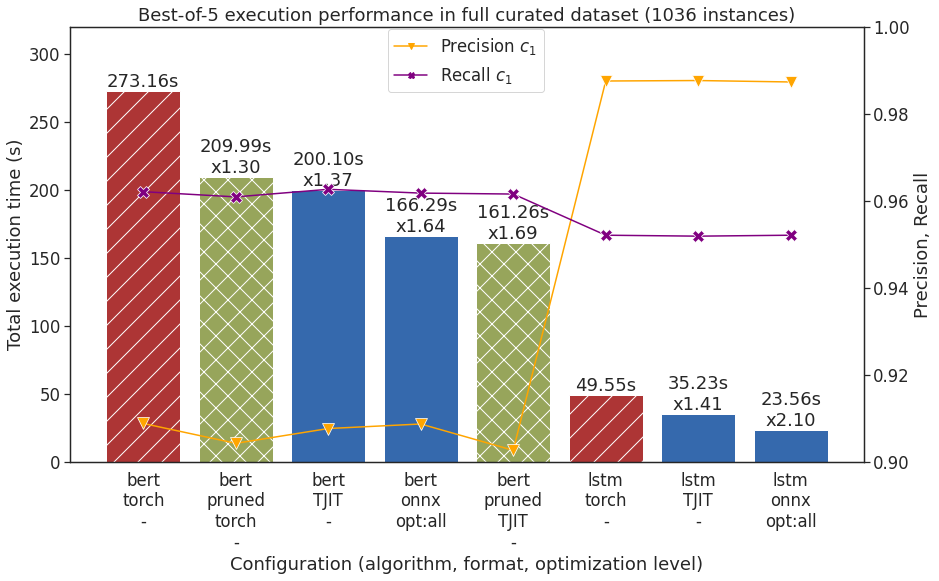

In [21]:
score_p = df_all_results["per_cls_precision_1"]
score_r = df_all_results["per_cls_recall_1"]

aux_df = np.vstack(
    (
        list(zip(df_all_results.index, ["Precision $c_{1}$"] * len(score_p), score_p.values)),
        list(zip(df_all_results.index, ["Recall $c_{1}$"] * len(score_r), score_r.values)),
    )
)

cols = ["Config", "Metric", "Score"]
lineplot_df = pd.DataFrame(aux_df, columns=cols)
lineplot_df["Score"] = lineplot_df["Score"].astype(float)

sns.set_theme(
    context="notebook",
    style="white",
    font_scale=1.5,
)

fig, ax1 = plt.subplots(1, figsize=(14.222, 8))
ax2 = ax1.twinx()

fn_hex_to_tuple = lambda hex_v: tuple(int(hex_v[i : i + 2], base=16) / 255 for i in range(0, 6, 2))

colors = {
    ("-", False): fn_hex_to_tuple("C12121"),
    ("-", True): fn_hex_to_tuple("9EB24E"),
    ("0", True): fn_hex_to_tuple("9EB24E"),
}

hatches = {
    ("-", False): r"/",
    ("-", True): r"X",
    ("0", True): r"X",
}

ax_sns_barplot = sns.barplot(
    x=[
        item.replace("99", "opt:all").replace("torch_jit", "TJIT").replace("0", "-")
        for item in df_all_results.index
    ],
    y="approx_inference_time",
    ax=ax1,
    data=df_all_results,
    palette=[
        colors.get((opt_level, is_pruned), fn_hex_to_tuple("2167C1"))
        for opt_level, is_pruned in df_all_results[["config_opt_level", "config_is_pruned"]].values
    ],
    hatch=[
        hatches.get((opt_level, is_pruned))
        for opt_level, is_pruned in df_all_results[["config_opt_level", "config_is_pruned"]].values
    ],
)

ax_sns_barplot.set(ylim=(0, 320))

ax_sns_lineplot = sns.lineplot(
    x="Config",
    y="Score",
    hue="Metric",
    style="Metric",
    ax=ax2,
    data=lineplot_df,
    legend="full",
    dashes=False,
    markers=["v", "X"],
    markersize=12,
    palette=["orange", "purple"],
)

ax_sns_lineplot.set(ylim=(0.90, 1.0))

plt.legend(loc=(0.40, 0.85))

ax_sns_lineplot.set_ylabel("Precision, Recall")

ax_sns_barplot.set_title(
    f"Best-of-5 execution performance in full curated dataset ({curated_df.shape[0]} instances)"
)
ax_sns_barplot.set_ylabel("Total execution time (s)")
ax_sns_barplot.set_xlabel("Configuration (algorithm, format, optimization level)")

base_exec_perf_bert = df_all_results.loc[
    (
        df_all_results[["config_opt_level", "config_model_type", "config_is_pruned"]]
        == ("-", "bert", False)
    ).all(axis="columns"),
    "approx_inference_time",
]

base_exec_perf_lstm = df_all_results.loc[
    (df_all_results[["config_opt_level", "config_model_type"]] == ("-", "lstm")).all(
        axis="columns"
    ),
    "approx_inference_time",
]

speed_ups = [
    (base_exec_perf_bert if model == "bert" else base_exec_perf_lstm) / inf_time
    for inf_time, model in df_all_results[["approx_inference_time", "config_model_type"]].values
]
speed_ups = np.asfarray(speed_ups).squeeze()

ax_sns_barplot.bar_label(
    ax_sns_barplot.containers[0],
    labels=map(
        lambda x: f"{x[1]:.2f}s" + (f"\nx{x[0]:.2f}" if x[0] > 1.0 else ""),
        zip(speed_ups, df_all_results["approx_inference_time"].values),
    ),
)

fig.savefig(
    fname=os.path.join(PERFORMANCE_LOGS_DIR, f"perf_plot_batch_size_{input_batch_size}.pdf"),
    format="pdf",
    bbox_inches="tight",
)

### Hardware specification for experiment above
- Architecture:            x86_64
  - CPU op-mode(s):        32-bit, 64-bit
  - Address sizes:         39 bits physical, 48 bits virtual
  - Byte Order:            Little Endian
- CPU(s):                  12
  - On-line CPU(s) list:   0-11
- Vendor ID:               GenuineIntel
  - Model name:            Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
    - CPU family:          6
    - Model:               158
    - Thread(s) per core:  2
    - Core(s) per socket:  6
    - Socket(s):           1
    - Stepping:            10
    - CPU max MHz:         4500,0000
    - CPU min MHz:         800,0000
    - BogoMIPS:            5202.65